<a href="https://colab.research.google.com/github/FelixSchmid/Reinforcement_Learning/blob/master/DPsolver_gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# importing the necessary libraries
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np

<img src="http://drive.google.com/uc?export=view&id=18q7KL4aV6McMtaid_1Let2aGkw6d4QYn" width=45%>

In [0]:
class GridWorld:
    """ 
    The environment: (see image)
    * cells: the agent can step on a cell. There is exactly one cell to start from.
    This is the top left corner. There is one terminal cell where the walking ends, 
    the agent can not leave it (blue).
    * obstacles: there are cells where the agent can not step. (gray)
    * agent: it can move from one cell to an other neighboring cell. 
    Possible directions: up, down, left, right. Each transition happens with probability 1.
    * reward: after each transition the agent receives -1 point. In the terminal cell, no reward
    received anymore.
    """
    def __init__(self, size, start_cell, obstacles, terminating_state):
        self.size = size
        self.start = start_cell
        self.obstacles = obstacles
        self.termin = terminating_state
        self.current_cell = self.start
    
    def reset(self):
        self.current_cell = self.start
    
    def transition(self, cell, action):
        # cell = (row, column) indices
        # action: 0 left, 1 up, 2 right, 3 down
        # returns: What will be the next state

        r_current = cell[0]
        c_current = cell[1]
        
        # left
        if action == 0:
          cell = (r_current,c_current-1)
        # up
        if action == 1:
          cell = (r_current-1,c_current)
        # right
        if action == 2:
          cell = (r_current,c_current+1)
        # down
        if action == 3:
          cell = (r_current+1,c_current)

        if (cell[0], cell[1]) in self.obstacles:
          # undo step if we hit an obst.
          cell = (r_current,c_current)

        if cell[0] < 0 \
             or cell[0] > self.size[0] -1 \
             or cell[1] < 0  \
             or cell[1] > self.size[1] -1 : 
          # undo steps if we left the board
          cell = (r_current, c_current)
        
        # update the current_cell the step
        self.current_cell = cell
        
        return cell


    def reward(self, cell, action):
        # ----- RETURN REWARD -----
        # -1 if not in the terminal state
        cell_state = cell
        if self.transition(cell, action) != self.termin:
          reward = -1
        else:
          reward = 0
        # we only want to know the reward of a pot. transition.
        # so, we undo the action which is done within def transition that we call
        # for doing the transition, we need to call transition alone.
        # probably there is a more elegant solution,
        # but it works this way
        self.current_cell = cell_state
        return reward

    def in_terminal(self):
        return self.current_cell == self.termin

In [0]:
class DPsolver:
    """
    This solver is based on the Bellman-equation and it is 
    solved by iteratively.
    The action-value is used to represent the utility of the 
    actions and states.
    """

    def __init__(self, gridworld, gamma, iterations):
        # setting parametes according to the input parameters
        self.gridworld = gridworld
        self.gamma = gamma
        self.iterations = iterations
        size = gridworld.size
        # initialize accumulaters
        self.cntr = 0
        self.sum_rewards = []
        self.path = []
        # initialize the table for Q-function 
        self.q_table = np.zeros((4,) + size)

    def step(self):
        rows, cols = self.gridworld.size  # ask for the size of the grid

        for r in range(rows):
            for c in range(cols):
                for action in range(4):
                    # get the reward 
                    cell_to_update = (r,c)
                    reward = self.gridworld.reward(cell_to_update, action)
                    # next step
                    cell_next = self.gridworld.transition(cell_to_update,action)
                    r2, c2 = cell_next
                    # policy: always take the next step with that is most valuable
                    next_rewards = max(self.q_table[:, r2, c2])
                    # compute Q-value and update
                    self.q_table[action, r, c] =  reward + self.gamma * next_rewards

        # increase the counter
        self.cntr += 1
        # add the return to the sum_rewards list
        self.sum_rewards.append(self.trajectory())

    def trajectory(self):
        # reset the gridworld
        self.gridworld.reset()
        # calculate the return along a trajectory followed by the current policy
        # when started from the start_cell
        self.path = []
        sum_rewards = 0
        i = 0
        while not self.gridworld.in_terminal() and i < 40 :
            r, c = self.gridworld.current_cell
            # take action with most value
            action = np.argmax(self.q_table[:, r, c])
            reward = self.gridworld.reward((r, c), action)
            # do the step
            self.gridworld.transition((r, c), action)
            # collect reward
            sum_rewards += reward
            i += 1
            # collect path
            self.path.append((r, c))
        return sum_rewards

    def is_learning_finished(self):
        return self.cntr >= self.iterations

        

In [0]:
def plot_learning_curve(ql):
    values = ql.sum_rewards
    x = list(range(len(values)))
    y = values
    plt.title('Sum rewards')
    plt.plot(x, y, 'ro')
    plt.show()

-40
-40
-40
-40
-40
-40
-40
-7


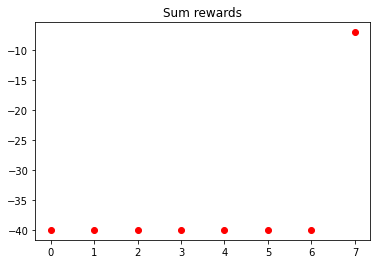

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 5), (2, 5)]


In [0]:
# grid world parameters
size = (6, 6)
start_cell = (0, 0)
obstacles = [(3, 3)]
terminating_state = (3, 5)
# q learning parameters
gamma = 0.9
iterations = 8

gw = GridWorld(size, start_cell, obstacles, terminating_state)
solver = DPsolver(gw, gamma, iterations)

while not solver.is_learning_finished():
    solver.step()
    sum_rewards = solver.sum_rewards[-1]
    print(sum_rewards)

sum_rewards = solver.trajectory()
plot_learning_curve(solver)
print(solver.path)

For the initially defined problem the algorithm needs 8 iterations until it succesfully finds the shortest way. In the following, I made the problem a little bit more challenging and it took the algorithm 10 iterations to solve it. 

Terminating state:
(0, 2)
Path:
[(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (3, 3), (2, 3), (1, 3), (1, 2)]
Obstacles:
[(0, 1), (1, 1), (2, 2)]


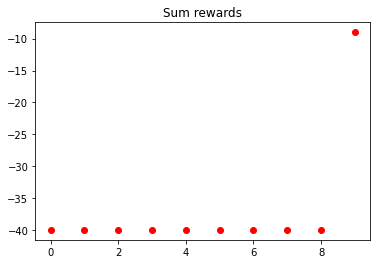

sum rewards for the last iteration:
-9


In [0]:
# same game with a bit more complicated task
size = (6, 6)
start_cell = (0, 0)
obstacles = [(0, 1), (1, 1), (2, 2)]
terminating_state = (0, 2)
# q learning parameters
gamma = 0.9
iterations = 10

gw = GridWorld(size, start_cell, obstacles, terminating_state)
solver = DPsolver(gw, gamma, iterations)

while not solver.is_learning_finished():
    solver.step()
print('Terminating state:')
print(terminating_state)
print('Path:')
print(solver.path)
print('Obstacles:')
print(obstacles)
plot_learning_curve(solver)
print('sum rewards for the last iteration:')
sum_rewards = solver.trajectory()
print(sum_rewards)